In [1]:
# | default_exp attention

%load_ext autoreload
%autoreload 2

%env TOKENIZERS_PARALLELISM=false
%env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

env: TOKENIZERS_PARALLELISM=false
env: PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import uuid
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime
from icecream import ic
import math
from my_transformer.utils import save_model, load_model
from transformers import AutoTokenizer

from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
import json
import os

# from rich import print
from rich.pretty import pprint

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataset

In [3]:
df = pd.read_csv("../dataset/bob_dylan_lyrics.csv")
lines = []
nb_rows = 999999
row_id = 0
for r in df.iterrows():
    # todo: one line is one sentence.
    lines.append(r[1]["title"])
    # sentences.append(r[1]["title"] + "\n" + r[1]["lyrics"])
    lyrics = r[1]["lyrics"].split("\n")
    for line in lyrics:
        if len(line.strip()) > 0:
            lines.append(line.strip())
        row_id += 1

lines[:10], len(lines)

(['Hard Times In New York Town',
  'Come you ladies and you gentlemen, a-listen to my song',
  'Sing it to you right, but you might think it’s wrong',
  'Just a little glimpse of a story I’ll tell',
  '’Bout an East Coast city that you all know well',
  'It’s hard times in the city',
  'Livin’ down in New York town',
  'Old New York City is a friendly old town',
  'From Washington Heights to Harlem on down',
  'There’s a-mighty many people all millin’ all around'],
 14318)

### Simple Custom Tokenizer for Bob Dylan Lyrics

Create a simple BPE (Byte-Pair Encoding) tokenizer trained specifically on Dylan's lyrics.


In [ ]:
class SimpleDylanTokenizer:
    def __init__(self, vocab_size=3000):
        vocab_size = vocab_size
        tokenizer = None

    def train_tokenizer(self, corpus: list[str], save_path: str = "./simple_dylan_tokenizer"):
        # Initialize simple BPE tokenizer
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

        # Simple whitespace pre-tokenization
        tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

        # Simple trainer
        trainer = BpeTrainer(
            vocab_size=self.vocab_size, special_tokens=["[PAD]", "[UNK]", "[MASK]"], min_frequency=2, show_progress=True
        )

        # Train the tokenizer
        tokenizer.train_from_iterator(corpus, trainer)

        # Save tokenizer
        os.makedirs(save_path, exist_ok=True)
        tokenizer.save(f"{save_path}/tokenizer.json")

        self.tokenizer = tokenizer
        print(f"Tokenizer trained and saved to {save_path}")

        return tokenizer

    def load_tokenizer(self, save_path="./simple_dylan_tokenizer"):
        """Load the trained tokenizer"""
        tokenizer_path = f"{save_path}/tokenizer.json"
        if os.path.exists(tokenizer_path):
            self.tokenizer = Tokenizer.from_file(tokenizer_path)
            return self.tokenizer
        else:
            raise FileNotFoundError(f"Tokenizer not found at {tokenizer_path}")

    def get_transformers_tokenizer(self):
        """Convert to HuggingFace tokenizer for compatibility"""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not trained or loaded")

        # Create fast tokenizer wrapper
        fast_tokenizer = PreTrainedTokenizerFast(
            tokenizer_object=self.tokenizer, pad_token="[PAD]", unk_token="[UNK]", mask_token="[MASK]"
        )

        return fast_tokenizer

In [5]:
# Initialize simple Dylan tokenizer
dylan_tokenizer = SimpleDylanTokenizer(vocab_size=3000)

# Train the tokenizer on Dylan lyrics
dylan_tokenizer.train_tokenizer(corpus=lines, save_path="./simple_dylan_tokenizer")

# Convert to HuggingFace format for compatibility
tokenizer = dylan_tokenizer.get_transformers_tokenizer()

ic(len(tokenizer))
ic(tokenizer.special_tokens_map)


phrase = "The answer my friend is blowin' in the wind"

tokens = tokenizer.encode(phrase, add_special_tokens=False)
decoded = tokenizer.decode(tokens, skip_special_tokens=False)
token_strs = tokenizer.convert_ids_to_tokens(tokens)
ic(phrase)
ic(decoded)
ic(token_strs);


ic| len(tokenizer): 3000
ic| tokenizer.special_tokens_map: {'mask_token': '[MASK]', 'pad_token': '[PAD]', 'unk_token': '[UNK]'}
| len(tokenizer): 3000
ic| tokenizer.special_tokens_map: {'mask_token': '[MASK]', 'pad_token': '[PAD]', 'unk_token': '[UNK]'}
ic| phrase: "The answer my friend is blowin' in the wind"
ic| decoded:ic| phrase: "The answer my friend is blowin' in the wind"
ic| decoded:




Tokenizer trained and saved to ./simple_dylan_tokenizer


 "The answer my friend is blowin ' in the wind"
ic| token_strs: ['The', 'answer',"The answer my friend is blowin ' in the wind"
ic| token_strs: ['The', 'answer', 'my', 'friend', 'is', 'blowin', "'", 'in', 'the', 'wind']
 'my', 'friend', 'is', 'blowin', "'", 'in', 'the', 'wind']


In [6]:
class SimpleDylanDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=128):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.examples = []
        max_seq_len = 0

        for line in texts:
            # Simple tokenization - no structure tokens
            tokens = tokenizer.encode(line.strip(), add_special_tokens=False)
            token_nb = len(tokens)
            max_seq_len = max(max_seq_len, token_nb)
            # Truncate if too long

            if token_nb > seq_len:
                tokens = tokens[:seq_len]

            if token_nb > 0:  # Skip empty sequences
                self.examples.append(tokens)
        print(f"Max sequence length in dataset: {max_seq_len}")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        tokens = self.examples[idx]
        pad_id = self.tokenizer.pad_token_id if hasattr(self.tokenizer, "pad_token_id") else 0

        # Pad to sequence length
        padded = tokens + [pad_id] * (self.seq_len - len(tokens))
        return torch.tensor(padded[: self.seq_len], dtype=torch.long)


seq_len = 20  # Keep shorter sequences for memory efficiency
batch_size = 8

# Create dataset with selected tokenizer
dataset = SimpleDylanDataset(lines, tokenizer, seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

ic(len(dataset))
ic(seq_len)
ic(len(tokenizer))

# Test the dataset
sample_batch = next(iter(dataloader))
ic(sample_batch.shape)
ic(tokenizer.decode(sample_batch[0].tolist(), skip_special_tokens=False));


ic| len(dataset): 14318
ic| seq_len: 20
ic| len(tokenizer): 3000
ic| len(dataset): 14318
ic| seq_len: 20
ic| len(tokenizer): 3000
ic| sample_batch.shape: torch.Size([8, 20])
ic| tokenizer.decode(sample_batch[0].tolist(), skip_special_tokens=False): ('He ’ s eat in ’ ch it lin s [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
| sample_batch.shape: torch.Size([8, 20])
ic| tokenizer.decode(sample_batch[0].tolist(), skip_special_tokens=False): ('He ’ s eat in ’ ch it lin s [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
                                                                            '[PAD] [PAD]')                                                                            '[PAD] [PAD]')



Max sequence length in dataset: 41


## Diffusion model

In [7]:
class UniformScheduler(nn.Module):
    """Simple uniform transition scheduler with linear noise schedule."""

    def __init__(self, num_classes: int, num_timesteps: int, beta_start: float = 0.0001, beta_end: float = 0.02):
        super().__init__()
        self.num_classes = num_classes
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Create schedule and transition matrices
        betas = self._create_linear_schedule()
        # so they are put to device automatically
        self.register_buffer("betas", betas)
        Q_t = self._create_transition_matrices()
        self.register_buffer("Q_t", Q_t)
        Q_bar_t = self._create_cumulative_matrices()
        self.register_buffer("Q_bar_t", Q_bar_t)

    def _create_linear_schedule(self) -> torch.Tensor:
        """Create linear beta schedule: β_t increases linearly from beta_start to beta_end."""
        return torch.linspace(self.beta_start, self.beta_end, self.num_timesteps)

    def _create_transition_matrices(self) -> torch.Tensor:
        """
        Create uniform transition matrices: Q_t = (1-β_t)I + β_t/K * 11^T

        This means:
        - Stay in same state with probability (1-β_t)
        - Transition to any state (including same) with probability β_t/K each
        """
        Q_matrices = torch.zeros(self.num_timesteps, self.num_classes, self.num_classes)

        for t in range(self.num_timesteps):
            beta_t = self.betas[t].item()

            # Diagonal: probability of staying in same state
            Q_t = (1 - beta_t) * torch.eye(self.num_classes)

            # Off-diagonal: uniform probability of transitioning to any state
            Q_t += beta_t / self.num_classes * torch.ones(self.num_classes, self.num_classes)

            Q_matrices[t] = Q_t

        return Q_matrices

    def _create_cumulative_matrices(self) -> torch.Tensor:
        """Create cumulative matrices: Q̄_t = Q_1 * Q_2 * ... * Q_t"""
        Q_bar_matrices = torch.zeros(self.num_timesteps, self.num_classes, self.num_classes)
        Q_bar_matrices[0] = self.Q_t[0]

        for t in range(1, self.num_timesteps):
            Q_bar_matrices[t] = torch.matmul(Q_bar_matrices[t - 1], self.Q_t[t])

        return Q_bar_matrices

    def add_noise(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Apply forward diffusion: sample from q(x_t | x_0).

        For uniform transitions, this uses the cumulative matrix Q̄_t.
        """
        batch_size, seq_len = x_0.shape
        device = x_0.device

        # Clamp x_0 to valid token range to prevent out-of-bounds errors
        x_0_clamped = torch.clamp(x_0, 0, self.num_classes - 1)

        # Convert to one-hot encoding
        x_0_onehot = F.one_hot(x_0_clamped, self.num_classes).to(device).float()  # [B, L, K]

        x_t = torch.zeros_like(x_0).to(device)  # [B, L]
        self.Q_bar_t = self.Q_bar_t.to(device)  # Ensure matrices are on the correct device
        for i in range(batch_size):
            # Get cumulative transition matrix for this timestep
            t_val = t[i].item()

            # Add bounds checking to prevent IndexError
            t_val = max(0, min(t_val, self.num_timesteps - 1))

            Q_bar = self.Q_bar_t[t_val].to(device)  # [K, K]

            # Compute transition probabilities: x_0 @ Q̄_t
            # This gives probability distribution over x_t for each position
            probs = torch.matmul(x_0_onehot[i], Q_bar)  # [L, K]

            # Add numerical stability: ensure probabilities are non-negative and sum to 1
            probs = torch.clamp(probs, min=1e-8)  # Ensure non-negative
            probs = probs / probs.sum(dim=-1, keepdim=True)  # Normalize

            # Sample from categorical distribution
            flat_probs = probs.view(-1, self.num_classes)  # [L, K]

            # Additional safety check for multinomial
            prob_sums = flat_probs.sum(dim=-1)
            if (prob_sums <= 0).any():
                print(f"Warning: Invalid probability distribution detected")
                print(f"prob_sums: {prob_sums}")
                print(f"flat_probs sample: {flat_probs[0]}")
                # Fallback to uniform distribution
                flat_probs = torch.ones_like(flat_probs) / self.num_classes

            flat_samples = torch.multinomial(flat_probs, 1).squeeze(-1)  # [L]
            x_t[i] = flat_samples

        return x_t

    def get_posterior_params(self, x_t: torch.Tensor, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute true posterior q(x_{t-1} | x_t, x_0) using Equation 3.

        From the paper: q(x_{t-1}|x_t,x_0) = Cat(x_{t-1}; p = x_t Q_t^T ⊙ x_0 Q̄_{t-1} / (x_0 Q̄_t x_t^T))

        This tells us: given we observe x_t at time t and know the original was x_0,
        what's the probability distribution over what x_{t-1} could have been?
        """
        batch_size, seq_len = x_t.shape
        device = x_t.device

        # Clamp token indices to valid range
        x_t_clamped = torch.clamp(x_t, 0, self.num_classes - 1)
        x_0_clamped = torch.clamp(x_0, 0, self.num_classes - 1)

        posteriors = torch.zeros(batch_size, seq_len, self.num_classes, device=device)

        for i, t_val in enumerate(t):
            # Add bounds checking here too
            t_val = max(0, min(t_val.item(), self.num_timesteps - 1))

            if t_val == 0:
                # Special case: t=0 means we're asking for q(x_{-1}|x_0, x_0)
                # This doesn't make physical sense, so return uniform or x_0
                # In practice, this case shouldn't occur in training
                posteriors[i] = F.one_hot(x_0_clamped[i], self.num_classes).float()
                continue

            # Get transition matrices
            Q_t = self.Q_t[t_val].to(device)  # [K, K] - single step t
            Q_bar_t_minus_1 = self.Q_bar_t[t_val - 1].to(device)  # [K, K] - cumulative to t-1
            Q_bar_t = self.Q_bar_t[t_val].to(device)  # [K, K] - cumulative to t

            # For each position in sequence
            for pos in range(seq_len):
                x_0_idx = x_0_clamped[i, pos].item()  # Original token index (clamped)
                x_t_idx = x_t_clamped[i, pos].item()  # Current token index (clamped)

                # Compute posterior using Bayes rule:
                # q(x_{t-1}|x_t,x_0) ∝ q(x_t|x_{t-1},x_0) * q(x_{t-1}|x_0)
                #                    = q(x_t|x_{t-1}) * q(x_{t-1}|x_0)  [Markov property]

                posterior = torch.zeros(self.num_classes, device=device)

                # For each possible value of x_{t-1}
                for x_prev_idx in range(self.num_classes):
                    # q(x_{t-1}|x_0): probability that x_{t-1} = x_prev_idx given x_0
                    q_prev_given_x0 = Q_bar_t_minus_1[x_0_idx, x_prev_idx]

                    # q(x_t|x_{t-1}): probability that x_t = x_t_idx given x_{t-1} = x_prev_idx
                    q_curr_given_prev = Q_t[x_prev_idx, x_t_idx]

                    # Joint probability
                    posterior[x_prev_idx] = q_curr_given_prev * q_prev_given_x0

                # Normalize to get proper probability distribution
                posterior_sum = posterior.sum()
                if posterior_sum > 1e-8:
                    posterior = posterior / posterior_sum
                else:
                    # Fallback to uniform if numerical issues
                    posterior = torch.ones(self.num_classes, device=device) / self.num_classes

                posteriors[i, pos] = posterior

        return posteriors

    def compute_kl_divergence(self, true_posterior: torch.Tensor, pred_posterior: torch.Tensor) -> torch.Tensor:
        """Compute KL[q(x_{t-1}|x_t,x_0) || p_θ(x_{t-1}|x_t)]"""
        kl = torch.sum(true_posterior * (torch.log(true_posterior + 1e-8) - torch.log(pred_posterior + 1e-8)), dim=-1)
        return kl

In [8]:
scheduler = UniformScheduler(num_classes=100, num_timesteps=1000).to(device)

x_0 = torch.tensor([[42, 15, 73]])  # Original tokens

# Check at different timesteps
for t_val in [1, 10, 50, 100, 500]:
    t = torch.tensor([t_val])
    x_t = scheduler.add_noise(x_0, t)

    true_posterior = scheduler.get_posterior_params(x_t, x_0, t)
    true_prev = true_posterior.argmax(dim=-1)

    print(
        f"t={t_val}: x_0: {x_0[0].tolist()}, x_t: {x_t[0].tolist()}, true x_{{t-1}}: {true_prev[0].tolist()},\nequals x_0: {true_prev[0].equal(x_0[0])}"
    )
scheduler.Q_t.device, scheduler.Q_bar_t.device
device

t=1: x_0: [42, 15, 73], x_t: [42, 15, 73], true x_{t-1}: [42, 15, 73],
equals x_0: True
t=10: x_0: [42, 15, 73], x_t: [42, 15, 73], true x_{t-1}: [42, 15, 73],
equals x_0: True
t=50: x_0: [42, 15, 73], x_t: [42, 15, 73], true x_{t-1}: [42, 15, 73],
equals x_0: True
t=100: x_0: [42, 15, 73], x_t: [42, 15, 73], true x_{t-1}: [42, 15, 73],
equals x_0: True
t=500: x_0: [42, 15, 73], x_t: [37, 94, 41], true x_{t-1}: [37, 94, 41],
equals x_0: False


device(type='mps')

In [9]:
"""Test that posterior evolves correctly as we move through timesteps."""
print("Testing posterior evolution...")

vocab_size = 5  # Very small for clear visualization
scheduler = UniformScheduler(num_classes=vocab_size, num_timesteps=10, beta_start=0.1, beta_end=0.9).to(device)

x_0 = torch.tensor([[1]])  # Single token, original = 1

print("Evolution of posterior q(x_{t-1} | x_t, x_0) as t increases:")
print("(Shows probability of each token being x_{t-1})")
print()

for t_val in range(1, 6):
    t = torch.tensor([t_val])
    x_t = scheduler.add_noise(x_0, t)
    posterior = scheduler.get_posterior_params(x_t, x_0, t)
    true_prev = posterior.argmax(dim=-1)

    print(
        f"t={t_val}, x_0=1, x_t={x_t[0, 0].item()},  P(x_{{t-1}} = k): {[f'{p:.3f}' for p in posterior[0, 0].tolist()]},Most likely x_{{t-1}}: {posterior[0, 0].argmax().item()}"
    )


Testing posterior evolution...
Evolution of posterior q(x_{t-1} | x_t, x_0) as t increases:
(Shows probability of each token being x_{t-1})

t=1, x_0=1, x_t=1,  P(x_{t-1} = k): ['0.001', '0.996', '0.001', '0.001', '0.001'],Most likely x_{t-1}: 1
t=2, x_0=1, x_t=2,  P(x_{t-1} = k): ['0.032', '0.461', '0.444', '0.032', '0.032'],Most likely x_{t-1}: 1
t=3, x_0=1, x_t=1,  P(x_{t-1} = k): ['0.015', '0.941', '0.015', '0.015', '0.015'],Most likely x_{t-1}: 1
t=4, x_0=1, x_t=0,  P(x_{t-1} = k): ['0.517', '0.260', '0.074', '0.074', '0.074'],Most likely x_{t-1}: 0
t=5, x_0=1, x_t=4,  P(x_{t-1} = k): ['0.097', '0.205', '0.097', '0.097', '0.504'],Most likely x_{t-1}: 4


In [10]:
# Generate some noisy sentences
inp = next(iter(dataloader)).to(device)
ic(inp.shape)

ds_scheduler = UniformScheduler(num_classes=len(tokenizer), num_timesteps=30)


def demo_noise(inp, line_nb, step):
    src_line = tokenizer.decode(inp[line_nb].cpu().numpy())
    noisy_inp = ds_scheduler.add_noise(inp[line_nb : line_nb + 1], torch.tensor([step]).to(device))
    noisy_line = tokenizer.decode(noisy_inp[0].cpu().numpy())
    return src_line, noisy_line


ic.disable()
ic.enable()
sent_nb = 4
print(demo_noise(inp, sent_nb, 0)[1])
print(demo_noise(inp, sent_nb, 12)[1])
print(demo_noise(inp, sent_nb, 20)[1])
print(demo_noise(inp, sent_nb, 29)[1])


ic| inp.shape: torch.Size([8, 20])
| inp.shape: torch.Size([8, 20])


Yes , here ’ s the story of the H ur rican e [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Yes , here ’ s the story of the H ur rican e [PAD] [PAD] [PAD] rag [PAD] [PAD] [PAD]
Yes Seen here vent s the story Mu the H desert rican such [PAD] [PAD] feels [PAD] [PAD] [PAD] wherever
Yes , walls ’ s ft story of the H ur rican e [PAD] rs [PAD] [PAD] [PAD] [PAD] carry


In [11]:
class SimpleD3PMModel(nn.Module):
    """Simple transformer model for D3PM."""

    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int,
        d_model: int = 256,
        num_heads: int = 8,
        num_layers: int = 4,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model

        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)

        # Time embedding for diffusion timestep
        self.time_embedding = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Linear(d_model, d_model))

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output head to predict x₀
        self.output_head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, vocab_size))

        self.dropout = nn.Dropout(dropout)

    def _get_time_embedding(self, t: torch.Tensor) -> torch.Tensor:
        """Create sinusoidal time embeddings like in original Transformer."""
        half_dim = self.d_model // 2

        # Create the frequency ratios
        freqs = torch.exp(
            -math.log(10000.0) * torch.arange(0, half_dim, dtype=torch.float32, device=t.device) / half_dim
        )

        # Expand dims to enable broadcasting: t is [batch_size], freqs is [half_dim]
        time_freqs = t.float()[:, None] * freqs[None, :]  # [batch_size, half_dim]

        # Create sin and cos components
        emb = torch.cat([torch.sin(time_freqs), torch.cos(time_freqs)], dim=1)  # [batch_size, d_model]

        if self.d_model % 2 == 1:  # Handle odd d_model
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)

        return self.time_embedding(emb)

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: predict x₀ from x_t.

        Args:
            x_t: Noisy tokens, shape [batch_size, seq_len]
            t: Timesteps, shape [batch_size]

        Returns:
            x0_logits: Predicted x₀ logits, shape [batch_size, seq_len, vocab_size]
        """
        batch_size, seq_len = x_t.shape
        device = x_t.device

        # Token embeddings
        token_emb = self.token_embedding(x_t)  # [B, L, D]

        # Position embeddings
        positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.position_embedding(positions)  # [B, L, D]

        # Time embeddings
        time_emb = self._get_time_embedding(t)  # [B, D]
        time_emb = time_emb.unsqueeze(1).expand(-1, seq_len, -1)  # [B, L, D]

        # Combine all embeddings
        x = self.dropout(token_emb + pos_emb + time_emb)  # [B, L, D]

        # Transformer processing
        x = self.transformer(x)  # [B, L, D]

        # Predict x₀ logits
        x0_logits = self.output_head(x)  # [B, L, vocab_size]

        return x0_logits


In [12]:
def compute_predicted_posterior(
    scheduler: UniformScheduler, x0_logits: torch.Tensor, x_t: torch.Tensor, t: torch.Tensor
) -> torch.Tensor:
    """
    Compute p_θ(x_{t-1}|x_t) using x₀-parameterization.

    From Equation 4: p_θ(x_{t-1}|x_t) ∝ Σ q(x_{t-1},x_t|x̃₀) p̃_θ(x̃₀|x_t)

    The true posterior is: q(x_{t-1}|x_t,x₀) ∝ q(x_t|x_{t-1}) q(x_{t-1}|x₀)

    This is a fully vectorized implementation with no loops.
    """
    batch_size, seq_len = x_t.shape
    device = x_t.device
    num_classes = scheduler.num_classes

    # Convert model logits to probabilities
    p_x0_given_xt = F.softmax(x0_logits, dim=-1)  # [B, L, K]

    # Initialize result tensor
    pred_posteriors = torch.zeros(batch_size, seq_len, num_classes, device=device)

    # Handle t=0 case separately (early return for efficiency)
    t_zero_mask = t == 0
    if t_zero_mask.any():
        # For t=0 cases, return softmax of x0_logits
        pred_posteriors[t_zero_mask] = p_x0_given_xt[t_zero_mask]

        # If all timesteps are 0, return early
        if t_zero_mask.all():
            return pred_posteriors

    # Process non-zero timesteps
    non_zero_mask = ~t_zero_mask
    if not non_zero_mask.any():
        return pred_posteriors

    # Get indices for non-zero timesteps
    t_non_zero = t[non_zero_mask]  # [N] where N = number of non-zero timesteps

    # Get transition matrices for all non-zero timesteps
    # Stack Q_t and Q_{t-1} matrices for vectorized operations
    Q_t_stack = torch.stack([scheduler.Q_t[t_val] for t_val in t_non_zero])  # [N, K, K]
    Q_t_minus_1_stack = torch.stack([scheduler.Q_t[t_val - 1] for t_val in t_non_zero])  # [N, K, K]

    # Get relevant data for non-zero timesteps
    x_t_non_zero = x_t[non_zero_mask]  # [N, L]
    p_x0_non_zero = p_x0_given_xt[non_zero_mask]  # [N, L, K]

    # Vectorized computation of posterior for all positions and timesteps
    # We need to compute: Σ_{x0} p(x0|xt) * q(x_{t-1}|xt,x0)
    # where q(x_{t-1}|xt,x0) ∝ q(xt|x_{t-1}) * q(x_{t-1}|x0)

    # Create index tensors for gathering
    batch_indices = torch.arange(len(t_non_zero), device=device)[:, None]  # [N, 1]
    x_t_indices = x_t_non_zero  # [N, L] - current token indices

    # For each possible x_{t-1} value, compute the posterior probability
    pred_posterior_non_zero = torch.zeros(len(t_non_zero), seq_len, num_classes, device=device)

    for x_prev in range(num_classes):
        # For this x_{t-1} value, compute contribution from all possible x0 values

        # q(x_t|x_{t-1}): transition probability from x_prev to current tokens
        # Shape operations: Q_t_stack[batch_indices, x_prev, x_t_indices]
        q_xt_given_xprev = Q_t_stack[batch_indices, x_prev, x_t_indices]  # [N, L]

        # Avoid division by zero
        Q_t_minus_1_vals = Q_t_minus_1_stack[batch_indices, x_prev, x_t_indices]  # [N, L]
        q_xt_given_xprev = q_xt_given_xprev / (Q_t_minus_1_vals + 1e-8)

        # q(x_{t-1}|x0): probability of being at x_prev given each possible x0
        # Q_t_minus_1_stack[:, x0_indices, x_prev] for all x0_indices
        q_xprev_given_x0 = Q_t_minus_1_stack[:, :, x_prev]  # [N, K]

        # Expand dimensions for broadcasting
        q_xt_given_xprev_expanded = q_xt_given_xprev[:, :, None]  # [N, L, 1]
        q_xprev_given_x0_expanded = q_xprev_given_x0[:, None, :]  # [N, 1, K]

        # Compute unnormalized posterior contribution for this x_{t-1}
        # Shape: [N, L, K] = [N, L, 1] * [N, 1, K] * [N, L, K]
        unnorm_contrib = q_xt_given_xprev_expanded * q_xprev_given_x0_expanded * p_x0_non_zero

        # Sum over all possible x0 values (marginalization)
        pred_posterior_non_zero[:, :, x_prev] = unnorm_contrib.sum(dim=-1)  # [N, L]

    # Normalize the posterior distributions
    pred_posterior_non_zero = pred_posterior_non_zero / (pred_posterior_non_zero.sum(dim=-1, keepdim=True) + 1e-8)

    # Place results back into the full tensor
    pred_posteriors[non_zero_mask] = pred_posterior_non_zero

    return pred_posteriors


batch_size = 8
vocab_size = 1000
seq_len = 20
num_timesteps = 50  # Total number of timesteps
t = torch.randint(0, num_timesteps, (batch_size,), device=device)
x_t = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)  # Simulated noisy input
x0_logits = torch.randn(batch_size, seq_len, vocab_size, device=device)  # Simulated model output
ic(x_t.shape, x0_logits.shape, t.shape)

scheduler = UniformScheduler(num_classes=vocab_size, num_timesteps=num_timesteps).to(device)
ic(scheduler.Q_t.shape, scheduler.Q_bar_t.shape)
pred_posterior = compute_predicted_posterior(scheduler=scheduler, x0_logits=x0_logits, x_t=x_t, t=t)

ic| x_t.shape: torch.Size([8, 20])
    x0_logits.shape: torch.Size([8, 20, 1000])
    t.shape: torch.Size([8])
| x_t.shape: torch.Size([8, 20])
    x0_logits.shape: torch.Size([8, 20, 1000])
    t.shape: torch.Size([8])
ic| scheduler.Q_t.shape: torch.Size([50, 1000, 1000])
    scheduler.Q_bar_t.shape: torch.Size([50, 1000, 1000])
ic| scheduler.Q_t.shape: torch.Size([50, 1000, 1000])
    scheduler.Q_bar_t.shape: torch.Size([50, 1000, 1000])


In [13]:
"""
Visual demonstration of compute_predicted_posterior function behavior.
"""
print("🎨 Visual demonstration of compute_predicted_posterior...")

# Use a very small example for clarity
demo_vocab_size = 4
demo_num_timesteps = 5
demo_scheduler = UniformScheduler(num_classes=demo_vocab_size, num_timesteps=demo_num_timesteps).to(device)
batch_size, seq_len = 2, 3

# Test different timesteps
for t_val in [0, 1, 3]:
    print(f"\n🔍 Timestep t = {t_val}:")

    t = torch.tensor([t_val, t_val], device=device)
    x_t = torch.tensor([[0, 1, 2], [2, 0, 1]], device=device)

    # Create logits that strongly prefer certain tokens
    x0_logits = torch.zeros(batch_size, seq_len, demo_vocab_size, device=device)
    x0_logits[0, 0, 0] = 5.0  # Strongly predict token 0 for position 0
    x0_logits[0, 1, 1] = 5.0  # Strongly predict token 1 for position 1
    x0_logits[0, 2, 2] = 5.0  # Strongly predict token 2 for position 2
    x0_logits[1, 0, 3] = 5.0  # Strongly predict token 3 for position 0
    x0_logits[1, 1, 0] = 5.0  # Strongly predict token 0 for position 1
    x0_logits[1, 2, 1] = 5.0  # Strongly predict token 1 for position 2

    result = compute_predicted_posterior(demo_scheduler, x0_logits, x_t, t)

    print(
        f"   Input x_t: {x_t.tolist()},  Predicted x0 (argmax): {F.softmax(x0_logits, dim=-1).argmax(dim=-1).tolist()}"
    )
    print(f"   Posterior p(x_{{t-1}}|x_t) for each position:")

    for b in range(batch_size):
        for pos in range(seq_len):
            posterior = result[b, pos]
            max_prob_token = posterior.argmax().item()
            max_prob = posterior.max().item()
            print(
                f"     Batch {b}, Pos {pos}: most likely x_{{t-1}} = {max_prob_token} (prob={max_prob:.3f})"
                f"full distribution: {[f'{p:.3f}' for p in posterior.tolist()]}"
            )

    # Show entropy (measure of uncertainty)
    entropy = -(result * torch.log(result + 1e-8)).sum(dim=-1)
    print(f"   Entropy (uncertainty): {entropy.tolist()}")

print(f"\n📊 Summary insights:")
print(f"   • At t=0: Returns exact softmax of model predictions")
print(f"   • At t>0: Incorporates diffusion process uncertainty")
print(f"   • Higher t → more uncertainty (higher entropy)")
print(f"   • Function respects probability constraints (sum=1, non-negative)")


🎨 Visual demonstration of compute_predicted_posterior...

🔍 Timestep t = 0:
   Input x_t: [[0, 1, 2], [2, 0, 1]],  Predicted x0 (argmax): [[0, 1, 2], [3, 0, 1]]
   Posterior p(x_{t-1}|x_t) for each position:
     Batch 0, Pos 0: most likely x_{t-1} = 0 (prob=0.980)full distribution: ['0.980', '0.007', '0.007', '0.007']
     Batch 0, Pos 1: most likely x_{t-1} = 1 (prob=0.980)full distribution: ['0.007', '0.980', '0.007', '0.007']
     Batch 0, Pos 2: most likely x_{t-1} = 2 (prob=0.980)full distribution: ['0.007', '0.007', '0.980', '0.007']
     Batch 1, Pos 0: most likely x_{t-1} = 3 (prob=0.980)full distribution: ['0.007', '0.007', '0.007', '0.980']
     Batch 1, Pos 1: most likely x_{t-1} = 0 (prob=0.980)full distribution: ['0.980', '0.007', '0.007', '0.007']
     Batch 1, Pos 2: most likely x_{t-1} = 1 (prob=0.980)full distribution: ['0.007', '0.980', '0.007', '0.007']
   Entropy (uncertainty): [[0.11907892674207687, 0.11907892674207687, 0.11907892674207687], [0.11907892674207687, 

In [ ]:
""" Training step on a single batch. """


def training_step(
    scheduler: UniformScheduler, model: SimpleD3PMModel, x_0: torch.Tensor, t: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    x_t = scheduler.add_noise(x_0, t)
    ic(x_t.shape)
    x0_logits = model(x_t, t)
    ic(x0_logits.shape)
    true_posterior = scheduler.get_posterior_params(x_t, x_0, t)
    # ic(true_posterior.shape)

    pred_posterior = compute_predicted_posterior(scheduler=scheduler, x0_logits=x0_logits, x_t=x_t, t=t)
    # ic(pred_posterior.shape)

    kl_terms = scheduler.compute_kl_divergence(true_posterior, pred_posterior)
    # ic(kl_terms.shape)
    return x0_logits, kl_terms


num_timesteps = 50
max_seq_len = 22
batch_size = 32
vocab_size = 1000
dylan_tokenizer = SimpleDylanTokenizer(vocab_size=1000)
dylan_tokenizer.train_tokenizer(corpus=lines, save_path=f"./simple_{vocab_size}_dylan_tokenizer")
tokenizer = dylan_tokenizer.get_transformers_tokenizer()
sm_dataset = SimpleDylanDataset(lines[:100], tokenizer, seq_len=seq_len)
sm_dataloader = DataLoader(sm_dataset, batch_size=batch_size, shuffle=True)


scheduler = UniformScheduler(num_classes=vocab_size, num_timesteps=num_timesteps, beta_start=0.0001, beta_end=0.02).to(
    device
)

model = SimpleD3PMModel(vocab_size=vocab_size, max_seq_len=max_seq_len, d_model=128, num_heads=2, num_layers=1).to(
    device
)

t = torch.randint(0, num_timesteps, (batch_size,), device=device)  # Changed from (batch_size, 1) to (batch_size,)
x_0 = next(iter(sm_dataloader))  # Get a batch from the small dataset
x_0 = x_0.to(device)
ic(x_0.shape)  # Should be [batch_size, seq_len]
# Forward pass
print("before training step")
x0_logits, kl_terms = training_step(scheduler=scheduler, model=model, x_0=x_0, t=t)
print("after training step")




Tokenizer trained and saved to ./simple_1000_dylan_tokenizer
Max sequence length in dataset: 22


ic| x_0.shape: torch.Size([32, 3])
| x_0.shape: torch.Size([32, 3])
ic| x_t.shape: torch.Size([32, 3])
ic| x_t.shape: torch.Size([32, 3])


before training step


ic| x0_logits.shape: torch.Size([32, 3, 1000])
| x0_logits.shape: torch.Size([32, 3, 1000])


after training step


In [15]:
import torch
import torch.nn.functional as F

# Assuming SimpleD3PMModel and UniformScheduler are defined elsewhere
# from your_model_definition import SimpleD3PMModel, UniformScheduler

# Simple model and scheduler setup for training
seq_len = 20
vocab_size = len(tokenizer)
num_timesteps = 50

# Create model and scheduler
model = SimpleD3PMModel(vocab_size=vocab_size, max_seq_len=seq_len).to(device)
scheduler = UniformScheduler(num_classes=vocab_size, num_timesteps=num_timesteps, beta_start=0.0001, beta_end=0.02).to(
    device
)


# Simple loss function
def d3pm_loss(
    x0_logits: torch.Tensor, kl_terms: torch.Tensor, x_0: torch.Tensor, lambda_weight: float = 0.001
) -> tuple[torch.Tensor, dict]:
    # VB loss: average KL terms
    vb_loss = kl_terms.mean()

    # Auxiliary loss: cross entropy between predicted x0 and true x0
    flat_logits = x0_logits.view(-1, vocab_size)
    flat_targets = x_0.view(-1)
    aux_loss = F.cross_entropy(flat_logits, flat_targets)

    # Total loss
    total_loss = vb_loss + lambda_weight * aux_loss

    return total_loss, {"total": total_loss, "vb": vb_loss, "aux": aux_loss}


# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

print("Model and scheduler created successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocab size: {vocab_size}")
print(f"Num timesteps: {num_timesteps}")


Model and scheduler created successfully!
Model parameters: 3,809,256
Vocab size: 1000
Num timesteps: 50


## Training loop




Tokenizer trained and saved to ./simple_1000_dylan_tokenizer
Max sequence length in dataset: 26
Epoch 0


epoch 1/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 7.0998
  Batch 1: Loss = 7.2222
  Batch 2: Loss = 7.0029
  Batch 3: Loss = 7.0429
Epoch 0 completed. Average Loss: 7.0920
Epoch 1


epoch 2/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 7.0096
  Batch 1: Loss = 7.0208
  Batch 2: Loss = 6.9288
  Batch 3: Loss = 6.8718
Epoch 1 completed. Average Loss: 6.9577
Epoch 2


epoch 3/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.8476
  Batch 1: Loss = 6.8689
  Batch 2: Loss = 6.7555
  Batch 3: Loss = 6.8193
Epoch 2 completed. Average Loss: 6.8228
Epoch 3


epoch 4/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.7583
  Batch 1: Loss = 6.7116
  Batch 2: Loss = 6.6082
  Batch 3: Loss = 6.7722
Epoch 3 completed. Average Loss: 6.7126
Epoch 4


epoch 5/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.6490
  Batch 1: Loss = 6.5517
  Batch 2: Loss = 6.6078
  Batch 3: Loss = 6.4862
Epoch 4 completed. Average Loss: 6.5737
Epoch 5


epoch 6/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.6309
  Batch 1: Loss = 6.3946
  Batch 2: Loss = 6.3643
  Batch 3: Loss = 6.4136
Epoch 5 completed. Average Loss: 6.4509
Epoch 6


epoch 7/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.3583
  Batch 1: Loss = 6.2544
  Batch 2: Loss = 6.5605
  Batch 3: Loss = 6.0924
Epoch 6 completed. Average Loss: 6.3164
Epoch 7


epoch 8/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.0321
  Batch 1: Loss = 6.1358
  Batch 2: Loss = 6.3136
  Batch 3: Loss = 6.0323
Epoch 7 completed. Average Loss: 6.1284
Epoch 8


epoch 9/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.0587
  Batch 1: Loss = 6.1084
  Batch 2: Loss = 6.0547
  Batch 3: Loss = 5.9406
Epoch 8 completed. Average Loss: 6.0406
Epoch 9


epoch 10/10:   0%|          | 0/4 [00:00<?, ?it/s]

  Batch 0: Loss = 6.1449
  Batch 1: Loss = 5.6857
  Batch 2: Loss = 5.9953
  Batch 3: Loss = 5.7868
Epoch 9 completed. Average Loss: 5.9032


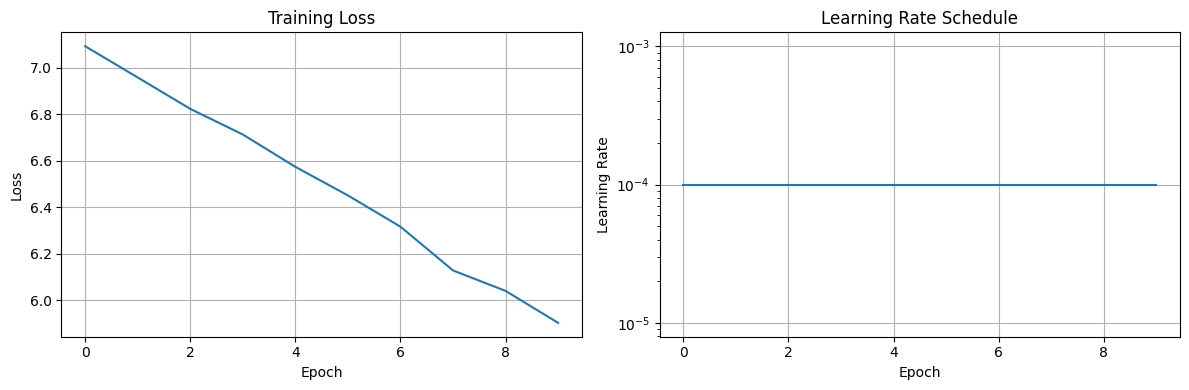


✅ Training loop working correctly! IndexError has been fixed.


In [56]:
from my_transformer import utils
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau

vocab_size = 1000
num_timesteps = 100
max_seq_len = 20
batch_size = 16

sm_lines = lines[:64]  # Use a smaller subset for testing
dylan_tokenizer = SimpleDylanTokenizer(vocab_size=vocab_size)
dylan_tokenizer.train_tokenizer(corpus=sm_lines, save_path=f"./simple_{vocab_size}_dylan_tokenizer")
tokenizer = dylan_tokenizer.get_transformers_tokenizer()
sm_dataset = SimpleDylanDataset(sm_lines, tokenizer, seq_len=seq_len)
sm_dataloader = DataLoader(sm_dataset, batch_size=batch_size, shuffle=True)

dataloader = sm_dataloader

model = SimpleD3PMModel(vocab_size=vocab_size, max_seq_len=max_seq_len, d_model=128, num_heads=2, num_layers=1).to(
    device
)

scheduler = UniformScheduler(num_classes=vocab_size, num_timesteps=num_timesteps, beta_start=0.0001, beta_end=0.02).to(
    device
)
do_train = True
if do_train:
    # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    learning_rate = 1e-4
    weight_decay = 1e-5  # Added weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Adaptive learning rate scheduler
    lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=1e-6)
    train_losses = []
    learning_rates = []
    model.train()

    # Training loop - IndexError fixed!
    num_epochs = 10

    model_name = "d3pm"
    model_version = "1.0"
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"../runs/{model_name}_{model_version}_training_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)

    global_step = 0
    num_batches = len(dataloader)
    ic(num_batches)

    ic.disable()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        model.train()
        epoch_loss = 0

        pbar = tqdm(dataloader, desc=f"epoch {epoch + 1}/{num_epochs}")

        for b, x_0 in enumerate(pbar):
            if b >= num_batches:
                break

            x_0 = x_0.to(device)
            batch_size = x_0.shape[0]

            # Sample random timesteps
            t = torch.randint(0, num_timesteps, (batch_size,), device=device)

            # Training step
            x0_logits, kl_terms = training_step(scheduler=scheduler, model=model, x_0=x_0, t=t)
            loss, loss_dict = d3pm_loss(x0_logits, kl_terms, x_0)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            global_step += 1
            current_lr = optimizer.param_groups[0]["lr"]
            avg_epoch_loss = epoch_loss / num_batches

            print(f"  Batch {b}: Loss = {loss.item():.4f}")
            if global_step % 2 == 0:
                writer.add_scalar("Loss/Batch", loss.item(), global_step)
                writer.add_scalar("Learning_Rate", current_lr, global_step)
                writer.add_scalar(
                    "Gradient_Norm",
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float("inf")),
                    global_step,
                )

            # Update progress bar
            pbar.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{current_lr:.2e}", "Step": global_step})

            # Memory cleanup
            if b % 5 == 0:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                elif torch.backends.mps.is_available():
                    torch.mps.empty_cache()

        train_losses.append(avg_epoch_loss)
        learning_rates.append(current_lr)

        utils.save_model(model, model_name=model_name, model_version=model_version, iter=epoch)
        print(f"Epoch {epoch} completed. Average Loss: {epoch_loss / num_batches:.4f}")

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curve
    ax1.plot(train_losses)
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Learning rate curve
    ax2.plot(learning_rates)
    ax2.set_title("Learning Rate Schedule")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Learning Rate")
    ax2.set_yscale("log")
    ax2.grid(True)

    plt.tight_layout()
    os.makedirs("../plots", exist_ok=True)
    plt.savefig(f"../plots/training_curves_{timestamp}.png", dpi=150, bbox_inches="tight")
    plt.show()

    writer.close()
    print("\n✅ Training loop working correctly! IndexError has been fixed.")

In [57]:
num_epochs

10

## Sampling output

In [58]:
model = utils.load_model(model_name=model_name, model_version=model_version, iter=num_epochs - 1).to(device)

In [59]:
ic.enable()
prompt_txt = "How does it feel"
prompt = torch.Tensor(tokenizer.encode(prompt_txt, add_special_tokens=True)).unsqueeze(0).to(device)
ic(prompt_txt)
temperature = 0.1

num_steps = 1

# Handle prompt
prompt_len = prompt.shape[1]

if prompt_len >= seq_len:
    # If prompt is longer than desired sequence, just return prompt
    raise ValueError("Prompt length exceeds sequence length.")

# Start from uniform random tokens
x = torch.randint(0, model.vocab_size, (1, seq_len), device=device)
x[:, :prompt_len] = prompt

# Create mask for which positions to generate (non-prompt positions)
generation_mask = torch.ones(seq_len, dtype=torch.bool, device=device)
generation_mask[:prompt_len] = False

# Reverse diffusion process
timesteps = torch.linspace(scheduler.num_timesteps - 1, 0, scheduler.num_timesteps, dtype=torch.long, device=device)

model.eval()
for i, t_val in enumerate(timesteps):
    t = torch.full((batch_size,), t_val, device=device)

    with torch.no_grad():
        # Predict x₀
        x0_logits = model(x, t)

        if i == len(timesteps) - 1:
            # Final step: use x₀ prediction directly
            new_x = torch.argmax(x0_logits, dim=-1)
        else:
            # Sample from x₀ prediction with temperature and top-k
            x0_probs = F.softmax(x0_logits / temperature, dim=-1)

            # Sample
            flat_probs = x0_probs.view(-1, model.vocab_size)
            flat_samples = torch.multinomial(flat_probs, 1).squeeze(-1)
            new_x = flat_samples.view(batch_size, seq_len)

        # Only update non-prompt positions
        x = torch.where(generation_mask.unsqueeze(0), new_x, x)

        # ic(x.shape)
        output_txt = tokenizer.decode(x[0].cpu().numpy(), skip_special_tokens=False)
        ic(output_txt)

ic| prompt_txt: 'How does it feel'
ic| output_txt: 'How d o es it f e e l [PAD] es [PAD] [PAD] ork j'
ic| output_txt: 'How d o es it f e e l [PAD] [PAD] [PAD] [PAD] no L an'
ic| output_txt: 'How d o es it f e e l [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ork an'
ic| output_txt: 'How d o es it f e e l [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ime an'
ic| output_txt: ('How d o es it f e e l [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
                 '[PAD] an')
ic| output_txt: ('How d o es it f e e l [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
                 '[PAD] an')
ic| output_txt: ('How d o es it f e e l [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
                 '[PAD] an')
ic| output_txt: ('How d o es it f e e l [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
                 '[PAD] an')
ic| output_txt: ('How d o es it f e e l [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
                 '[PAD] v')
ic| output_txt: ('How d 